# Dynamic Convolution

Unofficial implementation of Dynamic Convolutions. Approach from paper [Dynamic Convolution: Attention over Convolution Kernels](https://arxiv.org/pdf/1912.03458.pdf).

In [1]:
#!git clone https://github.com/TArdelean/DynamicConvolution.git

In [2]:
root_dir = '..' 
import os
import sys
sys.path.append(root_dir)

In [3]:
# !pip install python_papi  #Python binding for the Performance Application Programming Interface library used to count flops
# sudo sh -c 'echo -1 >/proc/sys/kernel/perf_event_paranoid'

In [4]:
import pandas as pd
import torch
import numpy as np
from utils.utils import profile
from models import dynamic_convolution_generator, Conv2dWrapper
from models import ResNet10, MobileNetV2, MobileNetV3

### Set-up models to evaluate performance

In [5]:
networks = [ResNet10, MobileNetV2, MobileNetV3]
convs = [("", Conv2dWrapper), ("DY", dynamic_convolution_generator(4, 4))]
width_multipliers = [0.25, 0.5, 1]

In [6]:
def profile_models(networks, convs, width_multipliers, x, num_classes, n_repeats):
    results = []
    for network in networks:
        for conv in convs:
            for wm in width_multipliers:
                model = network(conv[1], width_multiplier=wm, num_classes=num_classes)
                specs = {"model": conv[0] + network.__name__ + " x " + str(wm)}
                specs.update(profile(model, (x, 1), n_repeats))
                results.append(specs)
    res = pd.DataFrame(results)
    res["inf_time_95_ci"] = res["inf_time_std(ms)"] * 1.96 / np.sqrt(n_repeats)
    return res

### Profile using single input with small size 

We use input with size $[3, 54, 54]$ and $200$ output classes corresponding to Tiny ImageNet dataset

In [7]:
res_1_54 = profile_models(networks, convs, width_multipliers, torch.rand(1, 3, 54, 54), 200, 20)
display(res_1_54)

,model,params(M),flops(M),inf_time_mean(ms),inf_time_std(ms),inf_time_95_ci
0,ResNet10 x 0.25,0.333336,52.825228,6.163139,0.593935,0.260304
1,ResNet10 x 0.5,1.277800,122.835288,9.669995,0.385042,0.168752
2,ResNet10 x 1,5.000712,243.568724,19.300563,1.625348,0.712340
3,DYResNet10 x 0.25,1.259164,53.844851,9.444115,0.694568,0.304408
4,DYResNet10 x 0.5,4.979780,125.735813,18.614882,1.341042,0.587738
5,DYResNet10 x 1,19.806100,253.903178,55.673487,2.277891,0.998330
6,MobileNetV2 x 0.25,0.494312,6.561356,17.779120,0.904191,0.396279
7,MobileNetV2 x 0.5,0.943880,17.835962,24.552521,1.698114,0.744231
8,MobileNetV2 x 1,2.480072,54.999226,37.903972,1.655225,0.725434
9,DYMobileNetV2 x 0.25,1.327760,8.451366,34.874476,2.963840,1.298960


### Profile using single input with large size 

We use input with size $[3, 224, 224]$ and $10$ output classes corresponding to Imagenette dataset

In [8]:
res_1_224 = profile_models(networks, convs, width_multipliers, torch.rand(1, 3, 224, 224), 10, 20)
display(res_1_224)

,model,params(M),flops(M),inf_time_mean(ms),inf_time_std(ms),inf_time_95_ci
0,ResNet10 x 0.25,0.308826,268.186402,27.124190,2.610819,1.144242
1,ResNet10 x 0.5,1.228970,1049.610803,65.086343,4.884365,2.140667
2,ResNet10 x 1,4.903242,4104.345166,181.634638,21.526179,9.434264
3,DYResNet10 x 0.25,1.234654,270.017922,32.620505,1.904869,0.834846
4,DYResNet10 x 0.5,4.930950,1054.235268,81.256869,5.483137,2.403091
5,DYResNet10 x 1,19.708630,4118.123092,212.353484,9.908679,4.342670
6,MobileNetV2 x 0.25,0.250922,43.215230,26.387662,1.055205,0.462464
7,MobileNetV2 x 0.5,0.700490,101.785906,38.108613,1.840231,0.806517
8,MobileNetV2 x 1,2.236682,288.195854,70.817647,8.692097,3.809479
9,DYMobileNetV2 x 0.25,1.084370,45.959054,43.608796,1.966018,0.861645


### Profile using a batch with small image size 

We use input with size $[10, 3, 54, 54]$ and $200$ output classes corresponding to Tiny ImageNet dataset

In [9]:
res_10_54 = profile_models(networks, convs, width_multipliers, torch.rand(10, 3, 54, 54), 200, 20)
display(res_10_54)

,model,params(M),flops(M),inf_time_mean(ms),inf_time_std(ms),inf_time_95_ci
0,ResNet10 x 0.25,0.333336,151.436572,21.324410,2.158147,0.945850
1,ResNet10 x 0.5,1.277800,590.061674,48.423546,4.056932,1.778029
2,ResNet10 x 1,5.000712,2323.435870,105.378940,7.956145,3.486934
3,DYResNet10 x 0.25,1.259164,159.270468,38.439158,1.312155,0.575077
4,DYResNet10 x 0.5,4.979780,619.337889,123.477939,4.094421,1.794459
5,DYResNet10 x 1,19.806100,2436.872543,444.365708,18.606629,8.154715
6,MobileNetV2 x 0.25,0.494312,12.959320,26.891537,1.799779,0.788788
7,MobileNetV2 x 0.5,0.943880,29.903508,36.366118,1.817140,0.796397
8,MobileNetV2 x 1,2.480072,86.537668,57.474279,1.869921,0.819529
9,DYMobileNetV2 x 0.25,1.327760,24.632357,55.160326,2.864434,1.255393


### Profile using batch with large image size 

We use input with size $[10, 3, 224, 224]$ and $10$ output classes corresponding to Imagenette dataset

In [10]:
res_10_224 = profile_models(networks, convs, width_multipliers, torch.rand(10, 3, 224, 224), 10, 20)
display(res_10_224)

,model,params(M),flops(M),inf_time_mean(ms),inf_time_std(ms),inf_time_95_ci
0,ResNet10 x 0.25,0.308826,2656.271002,343.044482,19.822566,8.687623
1,ResNet10 x 0.5,1.228970,10367.612383,796.663297,48.274459,21.157214
2,ResNet10 x 1,4.903242,40903.771546,2506.782881,115.598055,50.663081
3,DYResNet10 x 0.25,1.234654,2672.892198,414.938014,12.406077,5.437203
4,DYResNet10 x 0.5,4.930950,10414.690922,878.690565,40.590804,17.789704
5,DYResNet10 x 1,19.708630,41051.778975,2520.868169,216.810294,95.021301
6,MobileNetV2 x 0.25,0.250922,153.564568,151.423125,4.114021,1.803049
7,MobileNetV2 x 0.5,0.700490,371.901062,239.727367,3.244922,1.422150
8,MobileNetV2 x 1,2.236682,1099.673736,410.900930,27.459548,12.034677
9,DYMobileNetV2 x 0.25,1.084370,169.805437,169.132360,7.431375,3.256944


In [11]:
x = torch.rand(1, 3, 54, 54)
n_classes = 200

In [12]:
params = []
flops = []
labels = []

In [13]:
def compute_specs(model, params, flops):
    specs = profile(model, (x, 1), 1)
    params.append(specs["params(M)"])
    flops.append(specs["flops(M)"])

In [14]:
width_multipliers = [0.5, 1]

In [15]:
for network in networks:
    for wm in width_multipliers:
        labels.append(network.__name__ + " x " + str(wm))
        params.append([])
        flops.append([])
        compute_specs(network(Conv2dWrapper, width_multiplier=wm, num_classes=n_classes), params[-1], flops[-1])
        for n_kernels in range(1, 11):
            compute_specs(network(dynamic_convolution_generator(n_kernels, 4), width_multiplier=wm, num_classes=n_classes), params[-1], flops[-1])

In [16]:
import matplotlib.pyplot as plt

In [17]:
flops = np.array(flops).T
params = np.array(params).T

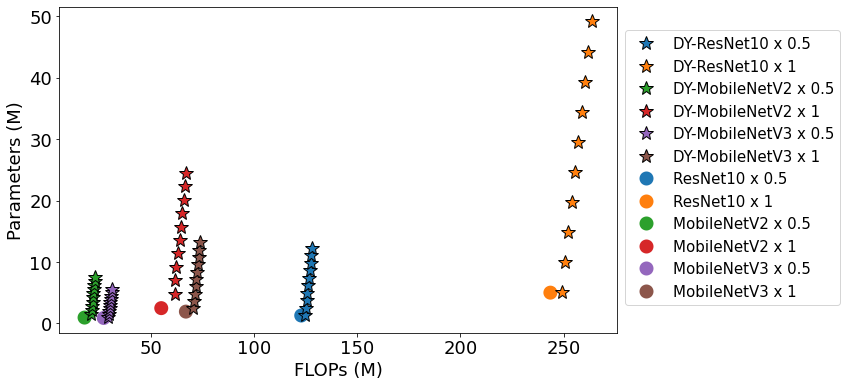

In [18]:
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(10, 6))
lines = plt.plot(flops[1:, :], params[1:, :], linewidth=2, marker="*", markersize=14, linestyle="", markeredgecolor="black");
circles = plt.scatter(flops[0, :], params[0, :], c=range(0, len(labels)), cmap=ListedColormap([l.get_color() for l in lines]), marker="o", linewidth=8)
plt.xlabel("FLOPs (M)", fontsize=18)
plt.ylabel("Parameters (M)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(lines + circles.legend_elements()[0], ["DY-" + l for l in labels] + labels, fontsize=15, bbox_to_anchor=(1, 0.95));
fig.savefig("plot.pdf", bbox_inches='tight');